In [2]:
import pandas as pd
from pyfaidx import Fasta
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
circRNA_df = pd.read_csv("/lulabdata3/huangkeyun/zhangys/RNA_locator/resources/circRNA subcellular localization information.txt",sep = '\t')
localization_df = circRNA_df

In [4]:
circRNA_df

,RNALocate_ID,Species,RNA_Symbol,RNA_Type,Subcellular_Localization,GO_Accession,PubMed_ID,RNALocate_Score
0,RL-E-circ-0938716,Mus musculus,mmu_circ_0001589,circRNA,Cell body,GO:0044297,34934923.0,0.694506
1,RL-E-circ-0938849,Mus musculus,mmu_circ_0000942,circRNA,Cytoplasm,GO:0005737,34751796.0,0.932913
2,RL-E-circ-0938857,Mus musculus,Btnl1,circRNA,Cytoplasm,GO:0005737,36715460.0,0.836757
3,RL-E-circ-0938858,Mus musculus,mmu_circ_0009559,circRNA,Cytoplasm,GO:0005737,38331014.0,0.904945
4,RL-E-circ-0938860,Mus musculus,mmu_circ_0002373,circRNA,Cytoplasm,GO:0005737,37913973.0,0.836757
...,...,...,...,...,...,...,...,...
134179,RL-E-circ-1072892,Homo sapiens,hsa_circ_0063332,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506
134180,RL-E-circ-1072893,Homo sapiens,hsa_circ_0000375,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.795006
134181,RL-E-circ-1072894,Homo sapiens,hsa_circ_0026102,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506
134182,RL-E-circ-1072896,Homo sapiens,hsa_circ_0000604,circRNA,Stress granule,NaN,35085777.0,0.836757


RNALocate_Score
0.328976    131814
0.396359       871
0.694506       688
0.836757       412
0.795006       168
0.904945        98
0.932913        33
0.815591        33
0.943642        22
0.428658        15
0.890460         8
0.901460         8
0.936216         6
0.441906         5
0.825458         3
Name: count, dtype: int64


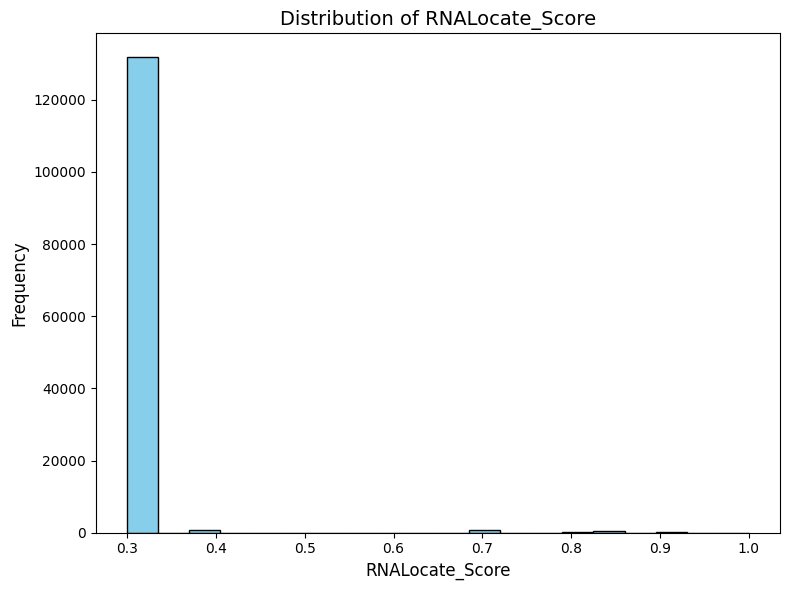

In [5]:
# 打印每种元素的计数
score_counts = circRNA_df['RNALocate_Score'].value_counts()
print(score_counts)

#  提取 RNALocate_Score 列并绘制直方图
plt.figure(figsize=(8, 6))
plt.hist(circRNA_df['RNALocate_Score'], bins=20, range=(0.3, 1.0), color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Distribution of RNALocate_Score', fontsize=14)
plt.xlabel('RNALocate_Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()


Subcellular_Localization
Extracellular vesicle          79308
Extracellular exosome          52730
Cytoplasm                        880
Nucleus                          482
Cytosol                          433
Membrane                         165
Nucleolus                         63
Nucleoplasm                       47
Chromatin                         46
Mitochondrion                      9
Microvesicle                       8
Stress granule                     2
Outside of the mitochondria        2
Perinuclear                        1
Endosome                           1
Cell body                          1
Around the nucleus                 1
Around the nuclear membrane        1
Ribosome                           1
Neurite                            1
Dendrite                           1
Soma                               1
Name: count, dtype: int64


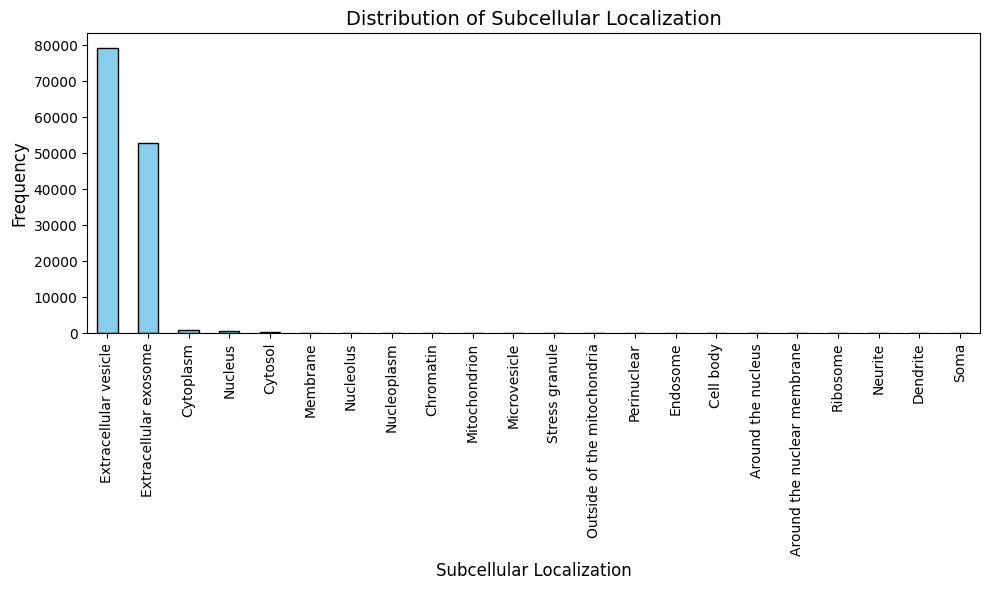

In [6]:
localization_counts = circRNA_df['Subcellular_Localization'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# 绘制柱状图
plt.figure(figsize=(10, 6))
localization_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Distribution of Subcellular Localization', fontsize=14)
plt.xlabel('Subcellular Localization', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()

截断后还有 2370 行数据


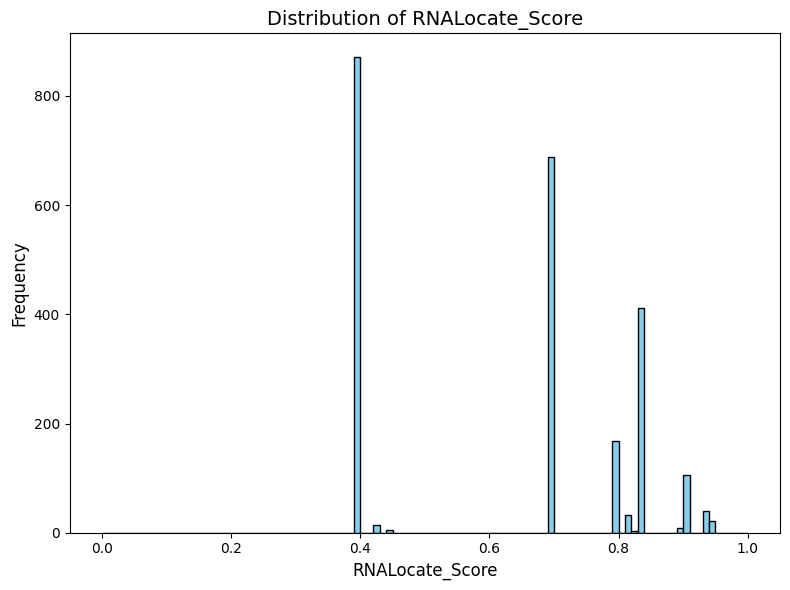

In [7]:
df_filtered = circRNA_df[circRNA_df['RNALocate_Score'] >= 0.39]

# 打印截断后的行数
print(f'截断后还有 {len(df_filtered)} 行数据')

# 绘制截断后的直方图
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['RNALocate_Score'], bins=100, range=(0, 1.0), color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Distribution of RNALocate_Score', fontsize=14)
plt.xlabel('RNALocate_Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()

Subcellular_Localization
Extracellular exosome          1059
Cytoplasm                       837
Extracellular vesicle           227
Nucleus                         209
Cytosol                          12
Mitochondrion                     9
Stress granule                    2
Outside of the mitochondria       2
Nucleolus                         2
Around the nucleus                1
Perinuclear                       1
Endosome                          1
Membrane                          1
Cell body                         1
Around the nuclear membrane       1
Soma                              1
Neurite                           1
Microvesicle                      1
Dendrite                          1
Ribosome                          1
Name: count, dtype: int64


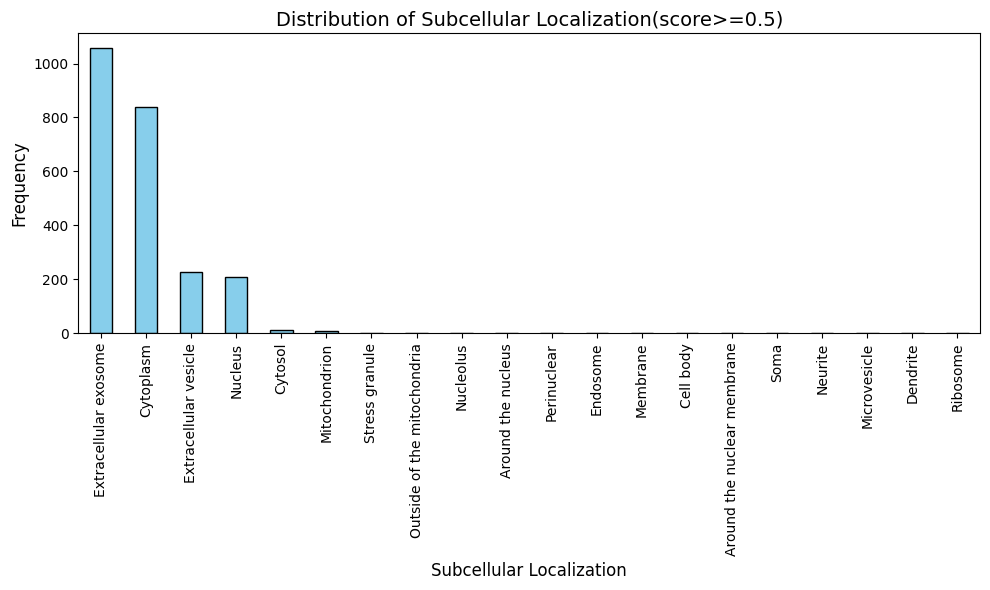

In [8]:
localization_counts = df_filtered['Subcellular_Localization'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# 绘制柱状图
plt.figure(figsize=(10, 6))
localization_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Distribution of Subcellular Localization(score>=0.5)', fontsize=14)
plt.xlabel('Subcellular Localization', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()

In [9]:
def process_rna_symbol(symbol):
    # 1. 如果字符串以 novel_ 开头，删除 novel_
    if symbol.startswith("novel_"):
        symbol = symbol[6:] 
    
    # 2. 仅保留包含 'hsa' 的行
    if "hsa" not in symbol and "mmu" not in symbol and "exo" not in symbol:
        return None  # 返回 None 用于之后的行过滤
    
    # 3. 将格式字符串中的piR和hsa调换位置
    parts = symbol.split('-')
    if len(parts) == 3 and parts[0] == "piR":
        symbol = f"hsa-piR-{parts[2]}" 
    
    return symbol

In [10]:
localization_df['RNA_Symbol'] = localization_df['RNA_Symbol'].apply(process_rna_symbol)

# 筛选 RNALocate_Score >= 0.38 的行
localization_df = localization_df[localization_df['RNALocate_Score'] >= 0.38]

# 创建tag列，默认值为0
localization_df['tag'] = 0

# 定义需要标记为1的位置类别
exosome_locations = ['Extracellular exosome', 'Extracellular vesicle', 'Microvesicle']

# 将符合条件的行的tag标记为1
mask = localization_df['Subcellular_Localization'].isin(exosome_locations)
localization_df.loc[mask, 'tag'] = 1

# 删除RNA_Symbol为空的行
localization_df.dropna(subset=['RNA_Symbol'], inplace=True)

/tmp/ipykernel_34577/1376507309.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localization_df['tag'] = 0
/tmp/ipykernel_34577/1376507309.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localization_df.dropna(subset=['RNA_Symbol'], inplace=True)


In [11]:
fasta_files = [
    "/lulabdata3/huangkeyun/zhangys/RNA_locator/references/circRNA/mouse_mm9_circRNAs_putative_spliced_sequence.fa",
    "/lulabdata3/huangkeyun/zhangys/RNA_locator/references/circRNA/hsa_circbase_seq.fa",
    "/lulabdata3/huangkeyun/zhangys/RNA_locator/references/circRNA/exo_circRNA_sequences.fa",
]

# 定义函数，解析FASTA文件并提取RNA_Symbol和序列
def parse_fasta(file_path):
    seq_dict = {}
    for record in SeqIO.parse(file_path, "fasta"):
        name = record.id
        sequence = str(record.seq)
        # 根据文件来源处理RNA_Symbol
        if "|" in name:  # 第一个文件
            symbol = name.split("|")[0]
        elif "(" in name:  # 第三个文件
            symbol = name.split("(")[0]
        else:  # 第二个文件
            symbol = name
        seq_dict[symbol] = sequence
    return seq_dict

# 合并所有FASTA文件中的RNA_Symbol和序列
rna_sequences = {}
for fasta in fasta_files:
    rna_sequences.update(parse_fasta(fasta))

# 加载CSV文件


# 根据RNA_Symbol添加Sequence列
localization_df["Sequence"] = localization_df.iloc[:, 2].map(rna_sequences).fillna("Sequence_not_found")



/tmp/ipykernel_34577/1280440269.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localization_df["Sequence"] = localization_df.iloc[:, 2].map(rna_sequences).fillna("Sequence_not_found")


In [12]:
# localization_df['Subcellular_Localization'] = localization_df['Subcellular_Localization'].replace({
#     'Cytoplasm': 'Cytosol',
#     'Extracellular exosome': 'Extracellular vesicle'
# })

# # 筛选仅保留指定的行
# valid_localizations = ['Cytosol', 'Extracellular vesicle', 'Nucleus']
# localization_df = localization_df[localization_df['Subcellular_Localization'].isin(valid_localizations)]

In [13]:
localization_df

,RNALocate_ID,Species,RNA_Symbol,RNA_Type,Subcellular_Localization,GO_Accession,PubMed_ID,RNALocate_Score,tag,Sequence
0,RL-E-circ-0938716,Mus musculus,mmu_circ_0001589,circRNA,Cell body,GO:0044297,34934923.0,0.694506,0,ATTGATGAACTCCCAGAGGGAGCTGTGAAGCCTCCAGCAAACAAGT...
1,RL-E-circ-0938849,Mus musculus,mmu_circ_0000942,circRNA,Cytoplasm,GO:0005737,34751796.0,0.932913,0,TTCGAAGGCTGCAAGAAGGCCTTTTCCAGGCTCGAGAACCTCAAGA...
3,RL-E-circ-0938858,Mus musculus,mmu_circ_0009559,circRNA,Cytoplasm,GO:0005737,38331014.0,0.904945,0,GTCTTATGGCAGCGTGTACAAGGCTATTCATAAAGAGACTGGCCAG...
4,RL-E-circ-0938860,Mus musculus,mmu_circ_0002373,circRNA,Cytoplasm,GO:0005737,37913973.0,0.836757,0,GATGACCAGACTCCACTCCACATCTCAGCCCGACTTGGGAAAGCTG...
5,RL-E-circ-0938888,Mus musculus,mmu_circ_0001572,circRNA,Cytoplasm,GO:0005737,33995660.0,0.836757,0,GTTAAAAAATCTCTCTAAGAGCCTGATTTTAGAGTTCACCAGCTCC...
...,...,...,...,...,...,...,...,...,...,...
134179,RL-E-circ-1072892,Homo sapiens,hsa_circ_0063332,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506,1,GTTAAGTTGGAGCCGACTCAGCGGCGGCCGCCATTTTGTGCAGTCG...
134180,RL-E-circ-1072893,Homo sapiens,hsa_circ_0000375,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.795006,1,GTCCCATCCATGGGGGGGCGGAAGCGGGAGCGCAAGGCTGCCGTCG...
134181,RL-E-circ-1072894,Homo sapiens,hsa_circ_0026102,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506,1,TGGGGGTCCGGTGCGGCGTTGTGCTCTCTGTAACTGCGGGGAGCCC...
134182,RL-E-circ-1072896,Homo sapiens,hsa_circ_0000604,circRNA,Stress granule,NaN,35085777.0,0.836757,0,GCGGGATCGCTTTGTTGGTCAAAGTGAGGGGAAAAAAGCACGACCT...


In [14]:
# 检查 'Sequence' 列是否包含 'N'、"Sequence_not_found" 或为空值，并删除这些行
original_row_count = len(localization_df)  # 原始行数
localization_df = localization_df[
    ~localization_df['Sequence'].str.contains('N', na=False)  # 保留不包含 'N' 的行
]
localization_df = localization_df[
    (localization_df['Sequence'] != "Sequence_not_found") &  # 删除值为 "Sequence_not_found" 的行
    localization_df['Sequence'].notna()  # 删除为空的行
]
new_row_count = len(localization_df)  # 处理后行数

# 计算删除的行数
deleted_rows = original_row_count - new_row_count

# 打印删除的行数
print(f"删除了 {deleted_rows} 行")

删除了 26 行


平均序列长度: 2162.42
序列长度分布（按分箱）：
49.0 - 3159.8: 1987 条序列
3159.8 - 6270.6: 73 条序列
6270.6 - 9381.4: 28 条序列
9381.4 - 12492.2: 22 条序列
12492.2 - 15603.0: 12 条序列
15603.0 - 18713.8: 6 条序列
18713.8 - 21824.6: 9 条序列
21824.6 - 24935.4: 10 条序列
24935.4 - 28046.2: 6 条序列
28046.2 - 31157.0: 4 条序列
31157.0 - 34267.8: 4 条序列
34267.8 - 37378.6: 8 条序列
37378.6 - 40489.4: 2 条序列
40489.4 - 43600.2: 4 条序列
43600.2 - 46711.0: 0 条序列
46711.0 - 49821.8: 4 条序列
49821.8 - 52932.6: 2 条序列
52932.6 - 56043.4: 2 条序列
56043.4 - 59154.2: 0 条序列
59154.2 - 62265.0: 2 条序列
62265.0 - 65375.8: 2 条序列
65375.8 - 68486.6: 0 条序列
68486.6 - 71597.4: 0 条序列
71597.4 - 74708.2: 0 条序列
74708.2 - 77819.0: 1 条序列
77819.0 - 80929.8: 0 条序列
80929.8 - 84040.6: 0 条序列
84040.6 - 87151.4: 2 条序列
87151.4 - 90262.2: 0 条序列
90262.2 - 93373.0: 2 条序列


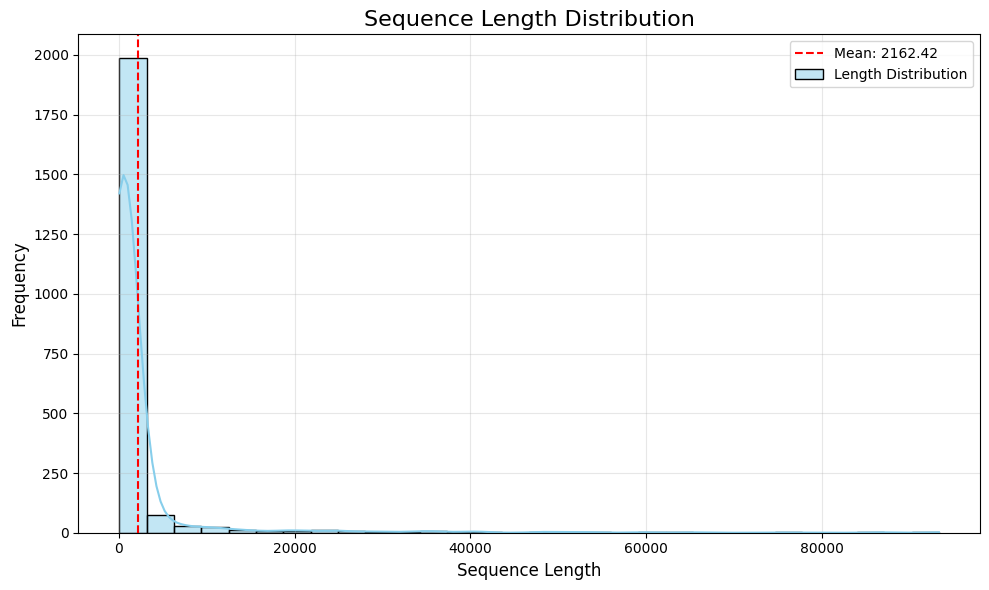

In [15]:
# 计算 Sequence 长度
localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()

# 统计平均值
average_length = localization_df['Sequence_Length'].mean()
print(f"平均序列长度: {average_length:.2f}")

# 设置分箱区间
bins = np.histogram_bin_edges(localization_df['Sequence_Length'], bins=30)  # 自动生成30个分箱
bin_counts, bin_edges = np.histogram(localization_df['Sequence_Length'], bins=bins)

# 打印每个分箱的序列数量
print("序列长度分布（按分箱）：")
for i in range(len(bin_counts)):
    print(f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {bin_counts[i]} 条序列")

# 绘制分布图
plt.figure(figsize=(10, 6))
sns.histplot(localization_df['Sequence_Length'], bins=bins, kde=True, color='skyblue', label='Length Distribution')

# 添加平均值的标注
plt.axvline(average_length, color='red', linestyle='--', label=f'Mean: {average_length:.2f}')

# 图形细节
plt.title('Sequence Length Distribution', fontsize=16)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示图形
plt.show()

In [16]:
# 删除长度过长的circRNA
localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()
original_row_count = len(localization_df)

# 删除 Sequence 长度大于 11238 的行，仍保存于localization_df
localization_df = localization_df[localization_df['Sequence_Length'] <= 11238]
new_row_count = len(localization_df)
deleted_rows = original_row_count - new_row_count
print(f"删除了 {deleted_rows} 行")


删除了 90 行


最短序列长度: 49
最长序列长度: 11198
平均序列长度: 921.61

序列长度分布（按分箱）：
49.0 - 420.6: 947 条序列
420.6 - 792.3: 536 条序列
792.3 - 1163.9: 252 条序列
1163.9 - 1535.5: 87 条序列
1535.5 - 1907.2: 68 条序列
1907.2 - 2278.8: 40 条序列
2278.8 - 2650.4: 25 条序列
2650.4 - 3022.1: 25 条序列
3022.1 - 3393.7: 13 条序列
3393.7 - 3765.3: 23 条序列
3765.3 - 4137.0: 10 条序列
4137.0 - 4508.6: 5 条序列
4508.6 - 4880.2: 14 条序列
4880.2 - 5251.9: 3 条序列
5251.9 - 5623.5: 4 条序列
5623.5 - 5995.1: 7 条序列
5995.1 - 6366.8: 1 条序列
6366.8 - 6738.4: 2 条序列
6738.4 - 7110.0: 3 条序列
7110.0 - 7481.7: 7 条序列
7481.7 - 7853.3: 6 条序列
7853.3 - 8224.9: 0 条序列
8224.9 - 8596.6: 5 条序列
8596.6 - 8968.2: 0 条序列
8968.2 - 9339.8: 3 条序列
9339.8 - 9711.5: 2 条序列
9711.5 - 10083.1: 2 条序列
10083.1 - 10454.7: 6 条序列
10454.7 - 10826.4: 4 条序列
10826.4 - 11198.0: 2 条序列


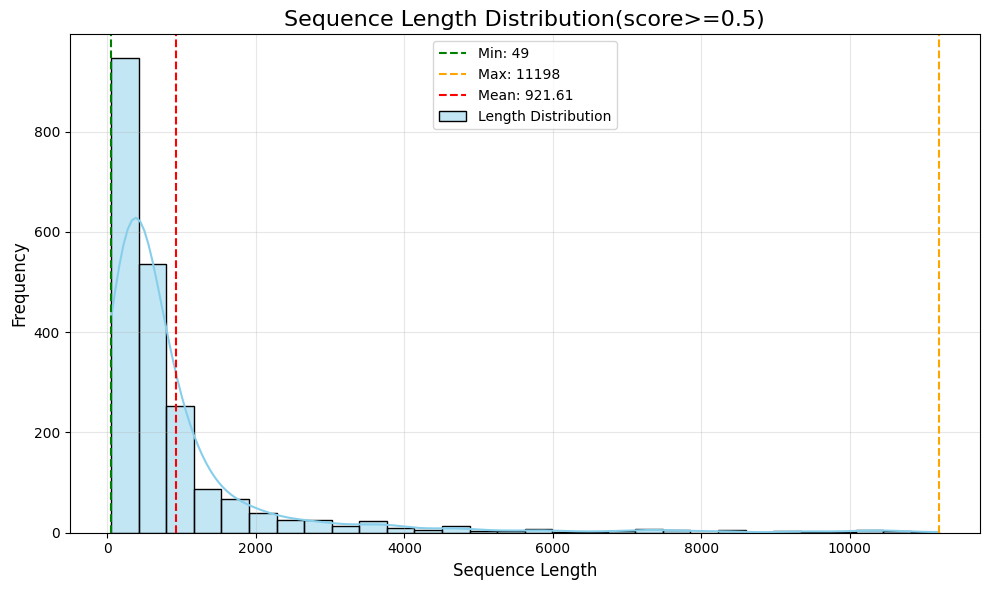

In [17]:
# 计算 Sequence 长度
localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()

# 统计最长、最短和平均值
max_length = localization_df['Sequence_Length'].max()
min_length = localization_df['Sequence_Length'].min()
average_length = localization_df['Sequence_Length'].mean()

print(f"最短序列长度: {min_length}")
print(f"最长序列长度: {max_length}")
print(f"平均序列长度: {average_length:.2f}")

# 设置分箱区间
bins = np.histogram_bin_edges(localization_df['Sequence_Length'], bins=30)  # 自动生成30个分箱
bin_counts, bin_edges = np.histogram(localization_df['Sequence_Length'], bins=bins)

# 打印每个分箱的序列数量
print("\n序列长度分布（按分箱）：")
for i in range(len(bin_counts)):
    print(f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {bin_counts[i]} 条序列")

# 绘制分布图
plt.figure(figsize=(10, 6))
sns.histplot(localization_df['Sequence_Length'], bins=bins, kde=True, color='skyblue', label='Length Distribution')

# 添加最小值、最大值和平均值的标注
plt.axvline(min_length, color='green', linestyle='--', label=f'Min: {min_length}')
plt.axvline(max_length, color='orange', linestyle='--', label=f'Max: {max_length}')
plt.axvline(average_length, color='red', linestyle='--', label=f'Mean: {average_length:.2f}')

# 图形细节
plt.title('Sequence Length Distribution(score>=0.5)', fontsize=16)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示图形
plt.show()

平均序列长度: 921.61
序列长度分布（按分箱）：
49.0 - 420.6: 947 条序列
420.6 - 792.3: 536 条序列
792.3 - 1163.9: 252 条序列
1163.9 - 1535.5: 87 条序列
1535.5 - 1907.2: 68 条序列
1907.2 - 2278.8: 40 条序列
2278.8 - 2650.4: 25 条序列
2650.4 - 3022.1: 25 条序列
3022.1 - 3393.7: 13 条序列
3393.7 - 3765.3: 23 条序列
3765.3 - 4137.0: 10 条序列
4137.0 - 4508.6: 5 条序列
4508.6 - 4880.2: 14 条序列
4880.2 - 5251.9: 3 条序列
5251.9 - 5623.5: 4 条序列
5623.5 - 5995.1: 7 条序列
5995.1 - 6366.8: 1 条序列
6366.8 - 6738.4: 2 条序列
6738.4 - 7110.0: 3 条序列
7110.0 - 7481.7: 7 条序列
7481.7 - 7853.3: 6 条序列
7853.3 - 8224.9: 0 条序列
8224.9 - 8596.6: 5 条序列
8596.6 - 8968.2: 0 条序列
8968.2 - 9339.8: 3 条序列
9339.8 - 9711.5: 2 条序列
9711.5 - 10083.1: 2 条序列
10083.1 - 10454.7: 6 条序列
10454.7 - 10826.4: 4 条序列
10826.4 - 11198.0: 2 条序列


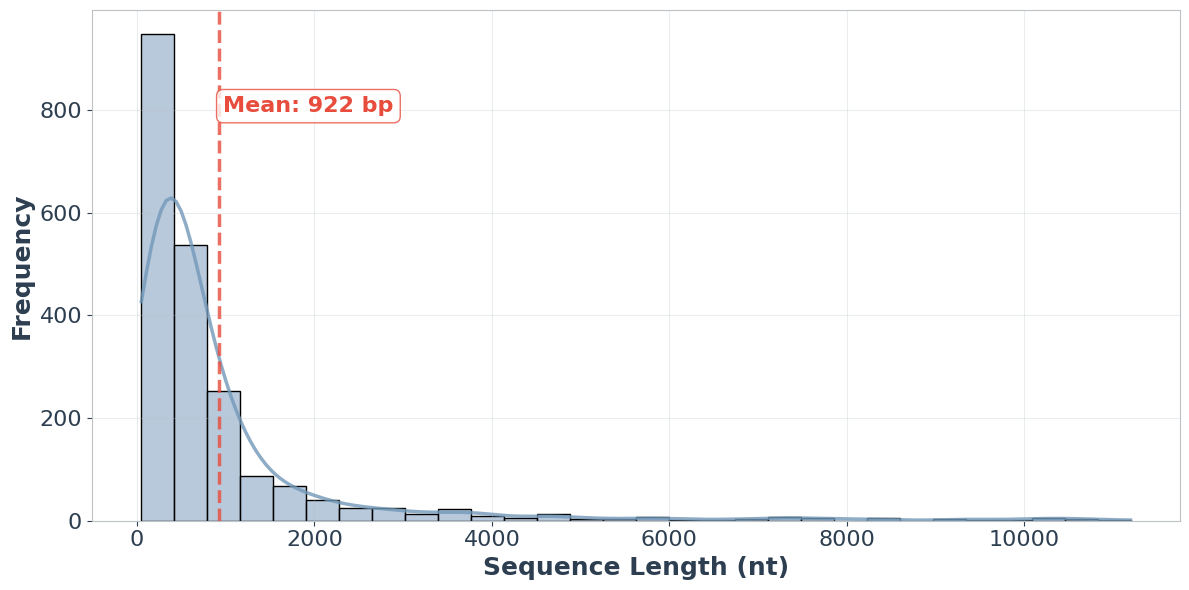

In [18]:
# 计算 Sequence 长度
localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()

# 统计平均值
average_length = localization_df['Sequence_Length'].mean()
print(f"平均序列长度: {average_length:.2f}")

# 设置分箱区间
bins = np.histogram_bin_edges(localization_df['Sequence_Length'], bins=30)  # 自动生成30个分箱
bin_counts, bin_edges = np.histogram(localization_df['Sequence_Length'], bins=bins)

# 打印每个分箱的序列数量
print("序列长度分布（按分箱）：")
for i in range(len(bin_counts)):
    print(f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {bin_counts[i]} 条序列")

# 设置图形样式
fig, ax = plt.subplots(figsize=(12, 6))

# 主色调配色方案
main_color = '#9AB2CC'
accent_color = '#E74C3C'
text_color = '#2C3E50'
kde_color = '#7298B8'

# 绘制分布图 - 先绘制直方图
sns.histplot(
    localization_df['Sequence_Length'], 
    bins=bins, 
    kde=False,  # 先不绘制KDE
    color=main_color,
    alpha=0.7,
    edgecolor='black',  # 改为黑色边框
    linewidth=1.0,      # 增加线宽
    ax=ax
)

# 手动添加KDE曲线
from scipy.stats import gaussian_kde
density = gaussian_kde(localization_df['Sequence_Length'])
xs = np.linspace(localization_df['Sequence_Length'].min(), 
                localization_df['Sequence_Length'].max(), 200)
density_values = density(xs)

# 缩放KDE曲线以匹配直方图的高度
density_values = density_values * len(localization_df) * (bins[1] - bins[0])

ax.plot(xs, density_values, color=kde_color, linewidth=2.5, alpha=0.8)

# 添加平均值的标注线
plt.axvline(
    average_length, 
    color=accent_color, 
    linestyle='--', 
    linewidth=2.5,
    alpha=0.8,
    label=f'Mean: {average_length:.0f} bp'
)

# 添加平均值文本标注
plt.text(
    average_length + 50, 
    plt.ylim()[1] * 0.8, 
    f'Mean: {average_length:.0f} bp',
    fontsize=16,
    color=accent_color,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=accent_color)
)

# 图形美化设置
# plt.title('Sequence Length Distribution (Score ≥ 0.38)', 
#           fontsize=18, 
#           fontweight='bold', 
#           color=text_color,
#           pad=20)
plt.xlabel('Sequence Length (nt)', fontsize=18, fontweight='bold', color=text_color)
plt.ylabel('Frequency', fontsize=18, fontweight='bold', color=text_color)

# 设置坐标轴样式
ax.spines['top'].set_visible(True)     # 显示顶部框线
ax.spines['right'].set_visible(True)   # 显示右侧框线
ax.spines['left'].set_visible(True)    # 显示左侧框线
ax.spines['bottom'].set_visible(True)  # 显示底部框线
# 设置框线颜色和样式
ax.spines['top'].set_color('#BDC3C7')
ax.spines['right'].set_color('#BDC3C7')
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
ax.tick_params(colors=text_color, labelsize=16)

# 网格设置
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, color='#BDC3C7')

# # 图例设置
# plt.legend(
#     fontsize=12, 
#     frameon=True, 
#     fancybox=True, 
#     shadow=True,
#     framealpha=0.9,
#     facecolor='white',
#     edgecolor=main_color
# )

# 调整布局
plt.tight_layout()

# 展示图形
plt.show()

Subcellular_Localization
Extracellular exosome          974
Cytoplasm                      721
Extracellular vesicle          213
Nucleus                        165
Cytosol                         10
Mitochondrion                    7
Nucleolus                        2
Stress granule                   2
Cell body                        1
Dendrite                         1
Neurite                          1
Ribosome                         1
Soma                             1
Around the nuclear membrane      1
Around the nucleus               1
Perinuclear                      1
Name: count, dtype: int64


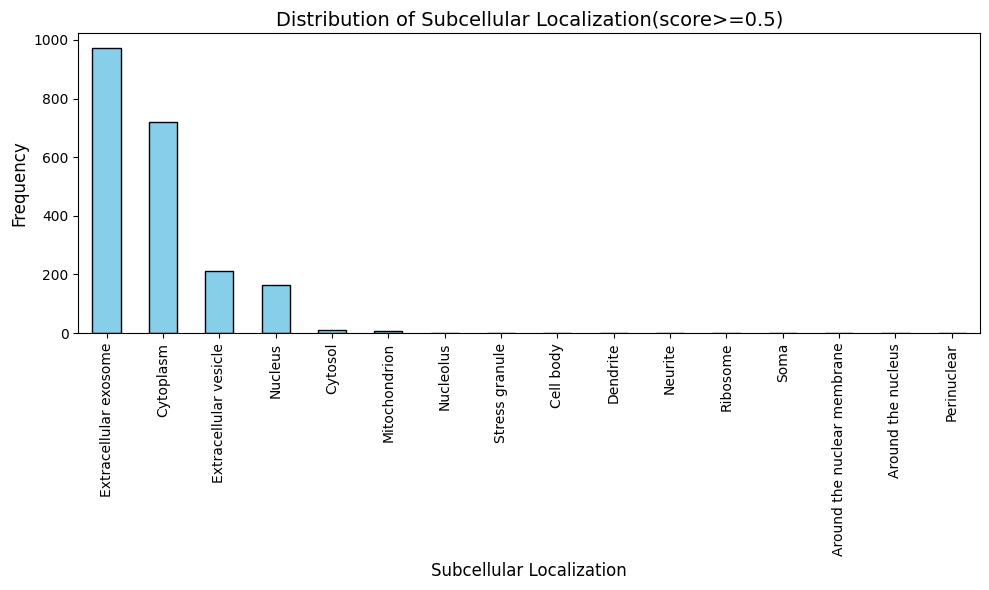

In [19]:
localization_counts = localization_df['Subcellular_Localization'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# 绘制柱状图
plt.figure(figsize=(10, 6))
localization_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Distribution of Subcellular Localization(score>=0.5)', fontsize=14)
plt.xlabel('Subcellular Localization', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()

tag
1    1187
0     915
Name: count, dtype: int64


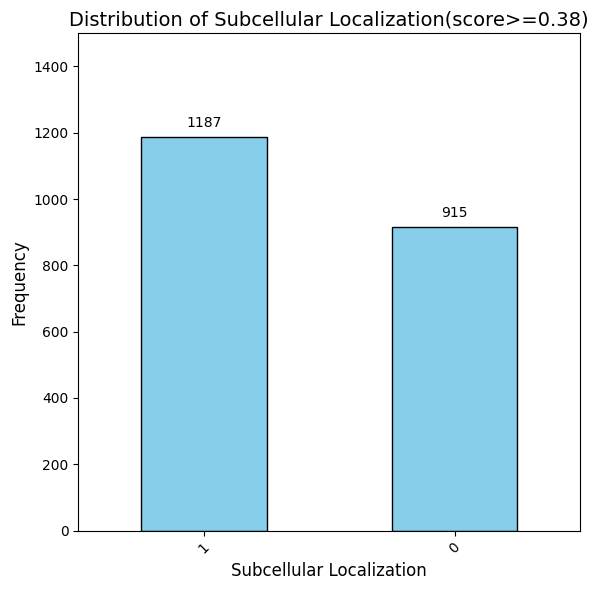

In [20]:

localization_counts = localization_df['tag'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# 绘制柱状图
plt.figure(figsize=(6, 6))
ax = localization_counts.plot(kind='bar', color='skyblue', edgecolor='black', width=0.5)

# 在每个柱子上方添加高度标签
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 添加标题和标签
plt.title('Distribution of Subcellular Localization(score>=0.38)', fontsize=14)
plt.xlabel('Subcellular Localization', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.ylim(0, 1500)  # 设置y轴范围
plt.xticks(rotation=45)

# 显示图形
plt.tight_layout()
plt.show()

tag
1    1187
0     915
Name: count, dtype: int64


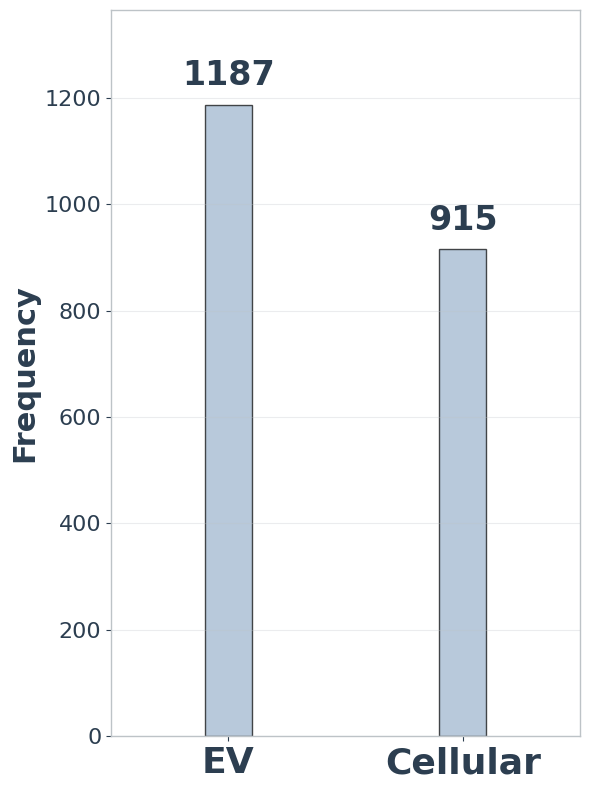


=== 自定义参数说明 ===
1. 柱子样式参数:
   - bar_width: 0.2 (柱子宽度, 建议范围: 0.1-1.0)
   - bar_spacing: 1.0 (柱子间距倍数, 建议范围: 0.5-2.0)

2. x轴文本样式参数:
   - xlabel_fontsize: 26 (字体大小)
   - xlabel_color: '#2C3E50' (字体颜色)
   - xlabel_rotation: 0 (旋转角度, 0-360)
   - xlabel_ha: 'center' (水平对齐: 'left', 'center', 'right')


In [21]:
localization_counts = localization_df['tag'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# ===== 用户自定义接口 =====
custom_labels = ['EV', 'Cellular']  

# 柱子样式参数
bar_width = 0.2        # 柱子宽度 (0.1-1.0)
bar_spacing = 1.0      # 柱子间距倍数 (0.5-2.0)

# x轴文本样式参数
xlabel_fontsize = 26   # x轴标签字体大小
number_fontsize = 24
xlabel_color = '#2C3E50'  # x轴标签颜色
xlabel_rotation = 0    # x轴标签旋转角度
xlabel_ha = 'center'   # x轴标签水平对齐方式 ('left', 'center', 'right')
# ========================

# 设置图形样式
fig, ax = plt.subplots(figsize=(6, 8))

# 主色调配色方案（与序列长度分布图一致）
main_color = '#9AB2CC'
accent_color = '#E74C3C'
text_color = '#2C3E50'

# 计算柱子位置（考虑间距）
positions = [i * bar_spacing for i in range(len(localization_counts))]

# 绘制柱状图
bars = ax.bar(
    positions, 
    localization_counts.values,
    color=main_color,
    alpha=0.7,
    edgecolor='black',
    linewidth=1.0,
    width=bar_width
)

# 在每个柱子上方添加高度标签
for i, (bar, count) in enumerate(zip(bars, localization_counts.values)):
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + max(localization_counts.values) * 0.02,  # 动态调整标签位置
        str(count),
        ha='center', 
        va='bottom',
        fontsize=number_fontsize,
        fontweight='bold',
        color=text_color
    )

# 图形美化设置
plt.ylabel('Frequency', fontsize=20, fontweight='bold', color=text_color)

# 设置x轴标签 - 修复对齐问题
ax.set_xticks(positions)  # 设置刻度位置与柱子位置一致
if custom_labels is not None and len(custom_labels) == len(localization_counts):
    # 使用自定义标签
    ax.set_xticklabels(
        custom_labels, 
        rotation=xlabel_rotation, 
        ha=xlabel_ha,
        fontsize=xlabel_fontsize,
        color=xlabel_color,
        fontweight='bold'
    )
else:
    # 使用原始标签
    ax.set_xticklabels(
        localization_counts.index, 
        rotation=xlabel_rotation, 
        ha=xlabel_ha,
        fontsize=xlabel_fontsize,
        color=xlabel_color,
        fontweight='bold'
    )

# 设置坐标轴样式
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('#BDC3C7')
# ax.spines['bottom'].set_color('#BDC3C7')
# 设置坐标轴样式 - 添加四周框线
ax.spines['top'].set_visible(True)     # 显示顶部框线
ax.spines['right'].set_visible(True)   # 显示右侧框线
ax.spines['left'].set_visible(True)    # 显示左侧框线
ax.spines['bottom'].set_visible(True)  # 显示底部框线
# 设置框线颜色和样式
ax.spines['top'].set_color('#BDC3C7')
ax.spines['right'].set_color('#BDC3C7')
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
# 可选：设置框线宽度
ax.spines['top'].set_linewidth(1.0)
ax.spines['right'].set_linewidth(1.0)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.tick_params(colors=text_color, labelsize=16)
ax.tick_params(axis='x', labelsize=xlabel_fontsize)
# 设置y轴范围
plt.ylim(0, max(localization_counts.values) * 1.15)

# 调整x轴范围以适应柱子间距
if len(positions) > 1:
    x_margin = bar_spacing * 0.5
    plt.xlim(-x_margin, positions[-1] + x_margin)
plt.ylabel('Frequency', fontsize=22, fontweight='bold', color=text_color)
# 网格设置
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, color='#BDC3C7', axis='y')

# 调整布局
plt.tight_layout()

# 展示图形
plt.show()

# ===== 使用说明 =====
print("\n=== 自定义参数说明 ===")
print("1. 柱子样式参数:")
print(f"   - bar_width: {bar_width} (柱子宽度, 建议范围: 0.1-1.0)")
print(f"   - bar_spacing: {bar_spacing} (柱子间距倍数, 建议范围: 0.5-2.0)")
print("\n2. x轴文本样式参数:")
print(f"   - xlabel_fontsize: {xlabel_fontsize} (字体大小)")
print(f"   - xlabel_color: '{xlabel_color}' (字体颜色)")
print(f"   - xlabel_rotation: {xlabel_rotation} (旋转角度, 0-360)")
print(f"   - xlabel_ha: '{xlabel_ha}' (水平对齐: 'left', 'center', 'right')")

tag
1    1187
0     915
Name: count, dtype: int64


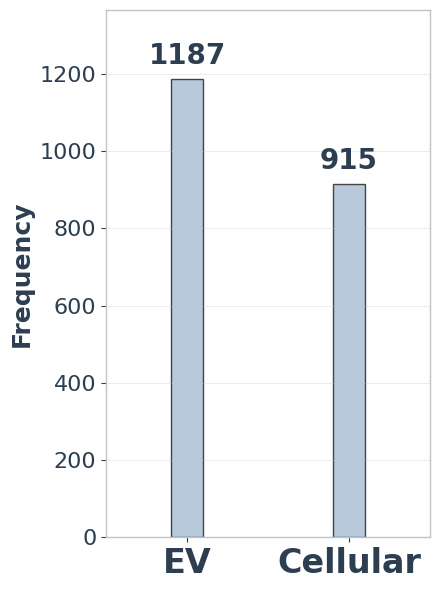


=== 自定义参数说明 ===
1. 柱子样式参数:
   - bar_width: 0.2 (柱子宽度, 建议范围: 0.1-1.0)
   - bar_spacing: 1.0 (柱子间距倍数, 建议范围: 0.5-2.0)

2. x轴文本样式参数:
   - xlabel_fontsize: 24 (字体大小)
   - xlabel_color: '#2C3E50' (字体颜色)
   - xlabel_rotation: 0 (旋转角度, 0-360)
   - xlabel_ha: 'center' (水平对齐: 'left', 'center', 'right')


In [22]:
localization_counts = localization_df['tag'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# ===== 用户自定义接口 =====
custom_labels = ['EV', 'Cellular']  

# 柱子样式参数
bar_width = 0.2        # 柱子宽度 (0.1-1.0)
bar_spacing = 1.0      # 柱子间距倍数 (0.5-2.0)

# x轴文本样式参数
xlabel_fontsize = 24   # x轴标签字体大小
number_fontsize = 20
xlabel_color = '#2C3E50'  # x轴标签颜色
xlabel_rotation = 0    # x轴标签旋转角度
xlabel_ha = 'center'   # x轴标签水平对齐方式 ('left', 'center', 'right')
# ========================

# 设置图形样式
fig, ax = plt.subplots(figsize=(4.5, 6))

# 主色调配色方案（与序列长度分布图一致）
main_color = '#9AB2CC'
accent_color = '#E74C3C'
text_color = '#2C3E50'

# 计算柱子位置（考虑间距）
positions = [i * bar_spacing for i in range(len(localization_counts))]

# 绘制柱状图
bars = ax.bar(
    positions, 
    localization_counts.values,
    color=main_color,
    alpha=0.7,
    edgecolor='black',
    linewidth=1.0,
    width=bar_width
)

# 在每个柱子上方添加高度标签
for i, (bar, count) in enumerate(zip(bars, localization_counts.values)):
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + max(localization_counts.values) * 0.02,  # 动态调整标签位置
        str(count),
        ha='center', 
        va='bottom',
        fontsize=number_fontsize,
        fontweight='bold',
        color=text_color
    )

# 图形美化设置
plt.ylabel('Frequency', fontsize=20, fontweight='bold', color=text_color)

# 设置x轴标签 - 修复对齐问题
ax.set_xticks(positions)  # 设置刻度位置与柱子位置一致
if custom_labels is not None and len(custom_labels) == len(localization_counts):
    # 使用自定义标签
    ax.set_xticklabels(
        custom_labels, 
        rotation=xlabel_rotation, 
        ha=xlabel_ha,
        fontsize=xlabel_fontsize,
        color=xlabel_color,
        fontweight='bold'
    )
else:
    # 使用原始标签
    ax.set_xticklabels(
        localization_counts.index, 
        rotation=xlabel_rotation, 
        ha=xlabel_ha,
        fontsize=xlabel_fontsize,
        color=xlabel_color,
        fontweight='bold'
    )

# 设置坐标轴样式
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('#BDC3C7')
# ax.spines['bottom'].set_color('#BDC3C7')
# 设置坐标轴样式 - 添加四周框线
ax.spines['top'].set_visible(True)     # 显示顶部框线
ax.spines['right'].set_visible(True)   # 显示右侧框线
ax.spines['left'].set_visible(True)    # 显示左侧框线
ax.spines['bottom'].set_visible(True)  # 显示底部框线
# 设置框线颜色和样式
ax.spines['top'].set_color('#BDC3C7')
ax.spines['right'].set_color('#BDC3C7')
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
# 可选：设置框线宽度
ax.spines['top'].set_linewidth(1.0)
ax.spines['right'].set_linewidth(1.0)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.tick_params(colors=text_color, labelsize=16)
ax.tick_params(axis='x', labelsize=xlabel_fontsize)
# 设置y轴范围
plt.ylim(0, max(localization_counts.values) * 1.15)

# 调整x轴范围以适应柱子间距
if len(positions) > 1:
    x_margin = bar_spacing * 0.5
    plt.xlim(-x_margin, positions[-1] + x_margin)
plt.ylabel('Frequency', fontsize=18, fontweight='bold', color=text_color)
# 网格设置
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.8, color='#BDC3C7', axis='y')

# 调整布局
plt.tight_layout()

# 展示图形
plt.show()

# ===== 使用说明 =====
print("\n=== 自定义参数说明 ===")
print("1. 柱子样式参数:")
print(f"   - bar_width: {bar_width} (柱子宽度, 建议范围: 0.1-1.0)")
print(f"   - bar_spacing: {bar_spacing} (柱子间距倍数, 建议范围: 0.5-2.0)")
print("\n2. x轴文本样式参数:")
print(f"   - xlabel_fontsize: {xlabel_fontsize} (字体大小)")
print(f"   - xlabel_color: '{xlabel_color}' (字体颜色)")
print(f"   - xlabel_rotation: {xlabel_rotation} (旋转角度, 0-360)")
print(f"   - xlabel_ha: '{xlabel_ha}' (水平对齐: 'left', 'center', 'right')")

In [23]:
output_csv = "./output_with_sequences.csv"  # 输出CSV文件
localization_df.to_csv(output_csv, sep="\t", index=False)

In [24]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# 分别筛选tag为0和1的数据
tag_0_df = localization_df[localization_df['tag'] == 0]
tag_1_df = localization_df[localization_df['tag'] == 1]

# 保存tag为0的序列到fasta文件
records_0 = []
for index, row in tag_0_df.iterrows():
    seq_id = f"{row['RNA_Symbol']}_{row['Subcellular_Localization']}"
    seq_record = SeqRecord(
        Seq(row['Sequence']),
        id=seq_id,
        description=""
    )
    records_0.append(seq_record)

SeqIO.write(records_0, "Cyto_sequences.fasta", "fasta")

# 保存tag为1的序列到fasta文件
records_1 = []
for index, row in tag_1_df.iterrows():
    seq_id = f"{row['RNA_Symbol']}_{row['Subcellular_Localization']}"
    seq_record = SeqRecord(
        Seq(row['Sequence']),
        id=seq_id,
        description=""
    )
    records_1.append(seq_record)

SeqIO.write(records_1, "EV_sequences.fasta", "fasta")

1187